<a href="https://colab.research.google.com/github/girinath18/stable_diffusion/blob/main/Stable_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/girinath18/stable_diffusion.git

Cloning into 'stable_diffusion'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!pip install diffusers mediapy transformers

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:	helicopter is landing in the forest 
Seed:	498301475486889663


""

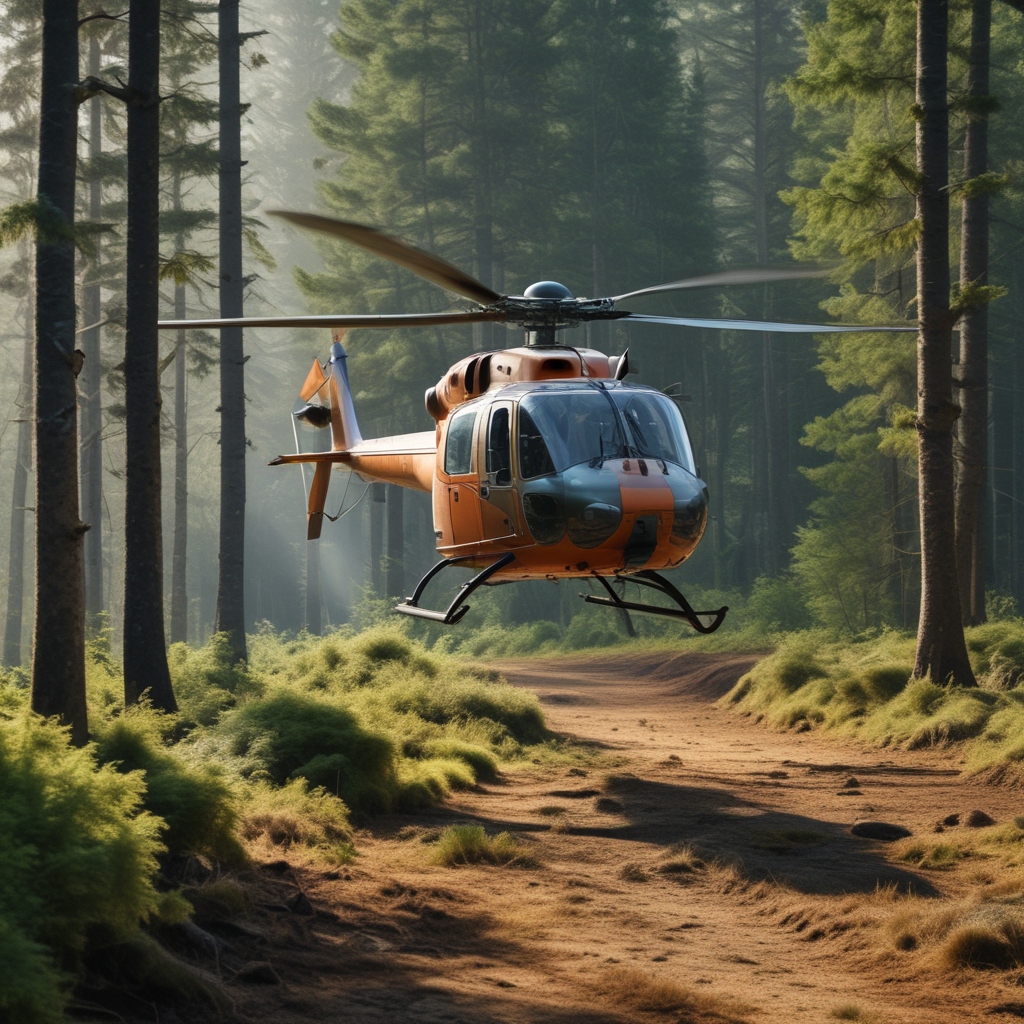

In [ ]:
import random
import sys
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
import mediapy as media

# Parameters
num_inference_steps = 4
use_lora = False
model_type = "lora" if use_lora else "unet"
base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = f"sdxl_lightning_{num_inference_steps}step_{model_type}.safetensors"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Main code
def main():
    # Load UNet model
    unet_config = UNet2DConditionModel.load_config(base, subfolder="unet")
    unet = UNet2DConditionModel.from_config(unet_config).to(device)

    unet.load_state_dict(
        load_file(
            hf_hub_download(
                repo,
                ckpt,
                ),
            device=device,
            ),
        )

    # Instantiate Stable Diffusion XL Pipeline
    pipe = StableDiffusionXLPipeline.from_pretrained(
        base,
        unet=unet,
        use_safetensors=True,
        variant="fp16",
        ).to(device)

    if use_lora:
        pipe.load_lora_weights(hf_hub_download(repo, ckpt))
        pipe.fuse_lora()

    pipe.scheduler = EulerDiscreteScheduler.from_config(
        pipe.scheduler.config,
        timestep_spacing="trailing",
        )

    # Additional code snippet
    prompt = "helicopter is landing in the forest "
    seed = random.randint(0, sys.maxsize)

    images = pipe(
        prompt=prompt,
        guidance_scale=0.0,
        num_inference_steps=num_inference_steps,
        generator=torch.Generator(device).manual_seed(seed),
        ).images

    print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
    media.show_images(images)
    images[0].save("output.jpg")

if __name__ == "__main__":
    main()
